# Notebook to Evaluate ORB-SLAM3 Performance
Built upon an ipynb file by Xinyi Liu

First, we install the requirements.

In [ ]:
!pip install evo
from evo.tools import log
log.configure_logging()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 980.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 16.6 MB/s eta 0:00:00
  Created wheel for evo: filename=evo-1.26.2-py3-none-any.whl size=141145 sha256=a608c4418bc8b4827e7db4463ead486370e8f298bc873cc5dbce934d064c274d
  Stored in directory: /root/.cache/pip/wheels/d2/54/e4/a8d9d1c1a39dcdb0a7116bba96390602eb815b3334a8400b49
Successfully built evo
Initialized new /root/.evo/settings.json


In [ ]:
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation, Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

---

## Load trajectories

In [ ]:
from evo.tools import file_interface
from evo.core import sync
import evo.main_ape as main_ape
import numpy as np
import matplotlib.pyplot as plt

1. **load TUM files with** 3D position and orientation quaternion per line ($x$ $y$ $z$ $q_x$ $q_y$ $q_z$ $q_w$)
2. Grid search to find a time offset value that minimizes rmse
3. Save the parameters for visualization

In [ ]:
# @title Hyperparameter Tuning
traj_ref_raw = file_interface.read_tum_trajectory_file("GT.txt")
traj_est_raw = file_interface.read_tum_trajectory_file("f_gan.txt")

# we are searching through offset region to find the minimum rmse for each categories
vals = np.logspace(4,8)

results = np.zeros(vals.shape[0])
for i in range(vals.shape[0]):
    val = vals[i]
    try:
        traj_ref, traj_est = sync.associate_trajectories(traj_ref_raw, traj_est_raw, max_diff=1e8, offset_2=val)
        result = main_ape.ape(traj_ref, traj_est, PoseRelation.translation_part, align=True, correct_scale=True)

        if result.trajectories["estimate"].num_poses >= 300:
            print("good matching")
            results[i] = result.stats["rmse"]
        else:
            print("poor matching")
            results[i] = np.NaN
    except:
        print('caught exception')
        results[i] = np.NaN

In [ ]:
# @title Graph the Results of Hyperparameter Tuning
print(results)
plt.plot(vals, results)
plt.xscale('log')
# plt.show()
vals[np.argmin(results)]

### Interactive APE Demo
***Run the code below, configure the parameters in the GUI, and press the "Run Interact" button.***

Our evaluation primarily uses the "full transformation" pose relation with the "align" and "correct_scale" options.

Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRelation.full_transformation: 'full transformation'>, 'translation part': <PoseRelation.translation_part: 'translation part'>, 'rotation part': <PoseRelation.rotation_part: 'rotation part'>, 'rotation angle in radians': <PoseRelation.rotation_angle_rad: 'rotation angle in radians'>, 'rotation angle in degrees': <PoseRelation.rotation_angle_deg: 'rotation angle in degrees'>, 'point distance': <PoseRelation.point_distance: 'point distance'>, 'point distance error ratio': <PoseRelation.point_distance_error_ratio: 'point distance error ratio'>}, value=<PoseRelation.translation_part: 'translation part'>)


interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

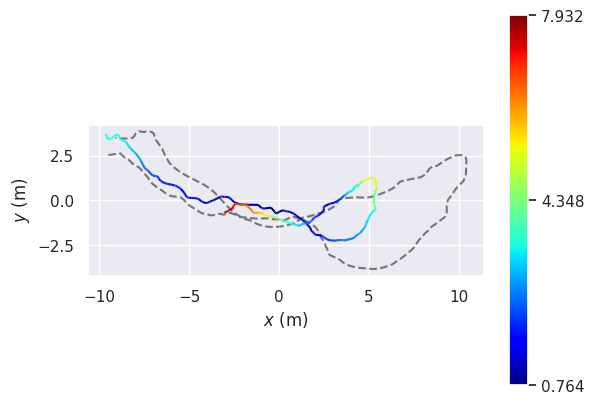

In [ ]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)

    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, align=align, correct_scale=correct_scale)
    count += 1
    results.append(result)

    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])

print(pose_relation_selector)

traj_ref_raw = file_interface.read_tum_trajectory_file("GT.txt")
traj_est_raw = file_interface.read_tum_trajectory_file("kf_inertial_dce.txt")


traj_ref, traj_est = sync.associate_trajectories(traj_ref_raw, traj_est_raw, max_diff=1e8, offset_2=1523957608053646848 - 1523957607455213652)

_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})